In [1]:
import scipy.io
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

In [2]:
# Load the .mat file
cam1 = scipy.io.loadmat('cam1.mat')  # Change filename accordingly
cam2 = scipy.io.loadmat('cam2.mat')  # Change filename accordingly
cam3 = scipy.io.loadmat('cam3.mat')  # Change filename accordingly

cam_1 = cam1['vidFrames1_4']
cam_2 = cam2['vidFrames2_4']
cam_3 = cam3['vidFrames3_4']

In [91]:
def crop_dataset(dataset, x_min, x_max, y_min, y_max):
    """
    Crops the dataset to the given pixel range without rotating.

    Parameters:
    - dataset: numpy array (H, W, C, F) - Video dataset
    - x_min, x_max: int - Pixel range for cropping in the X direction
    - y_min, y_max: int - Pixel range for cropping in the Y direction

    Returns:
    - Processed dataset (cropped)
    """
    num_frames = dataset.shape[3]  # Number of frames

    # Initialize an array for the processed dataset
    processed_dataset = np.zeros((y_max - y_min, x_max - x_min, 3, num_frames), dtype=np.uint8)

    for i in range(num_frames):
        frame = dataset[:, :, :, i]  # Extract the i-th frame
        cropped_frame = frame[y_min:y_max, x_min:x_max]  # Crop the frame
        processed_dataset[:, :, :, i] = cropped_frame  # Store the processed frame

    return processed_dataset

def rotate_dataset(dataset, rotation_angle):
    """
    Rotates the dataset clockwise by the given angle without cropping.

    Parameters:
    - dataset: numpy array (H, W, C, F) - Video dataset
    - rotation_angle: float - Rotation angle in degrees (clockwise)

    Returns:
    - Processed dataset (rotated without cropping)
    """
    num_frames = dataset.shape[3]  # Number of frames
    h, w = dataset.shape[:2]  # Original height and width

    # Initialize an array for the rotated dataset
    rotated_dataset = np.zeros_like(dataset)

    for i in range(num_frames):
        frame = dataset[:, :, :, i]  # Extract the i-th frame

        # Rotate the frame
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, -rotation_angle, 1)  # Negative for clockwise rotation
        rotated_frame = cv2.warpAffine(frame, rotation_matrix, (w, h))

        # Store the processed frame
        rotated_dataset[:, :, :, i] = rotated_frame

    return rotated_dataset

def create_video_from_dataset(dataset, output_video, fps=30):
    """
    Creates a video file from a dataset of frames.
    
    Parameters:
    - dataset: numpy array (H, W, C, F) - Processed video frames.
    - output_video: str - Output video filename.
    - fps: int - Frames per second.
    
    Returns:
    - None (saves the video file)
    """
    num_frames = dataset.shape[3]
    height, width = dataset.shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*'avc1')  # Use 'mp4v' instead of 'mp4'
    out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))
    
    for i in range(num_frames):
        frame = dataset[:, :, :, i]
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame_bgr)
    
    out.release()
    print(f"Video saved: {output_video}")

def save_dataset(data, filename):
    """
    Saves a cropped dataset into an .npz file under the key 'data'.

    Parameters:
    - data (numpy.ndarray): The cropped dataset to save. Expected shape: (H, W, C, F).
    - filename (str): The path where the dataset should be saved (must end with .npz).

    Returns:
    - None
    """
    if not filename.endswith(".npz"):
        raise ValueError("Filename must end with .npz")

    np.savez_compressed(filename, data=data)
    print(f"Dataset saved successfully to '{filename}'.")

# Example usage:
# save_dataset(cropped_data, "camera1_cropped.npz")

In [4]:
#Run this to load a raw dataset without cropping to compare with

data = scipy.io.loadmat('cam3.mat')

# Print keys to see available variables
print(data.keys())
keys = list(data.keys())
vid_frames = data[keys[-1]]
print(vid_frames.shape)

dict_keys(['__header__', '__version__', '__globals__', 'vidFrames3_4'])
(480, 640, 3, 394)


In [190]:
#Cropping the videos
dataset1 = crop_dataset(cam_1, 300, 500, 220, 450)

dataset2 = crop_dataset(cam_2, 200, 480, 60, 400)

cropped_dataset3 = crop_dataset(cam_3, 300, 500, 130, 300)
#cropped_dataset3 = crop_dataset(cam_3, 300, 510, 130, 300)
dataset3 = rotate_dataset(cropped_dataset3, 90)

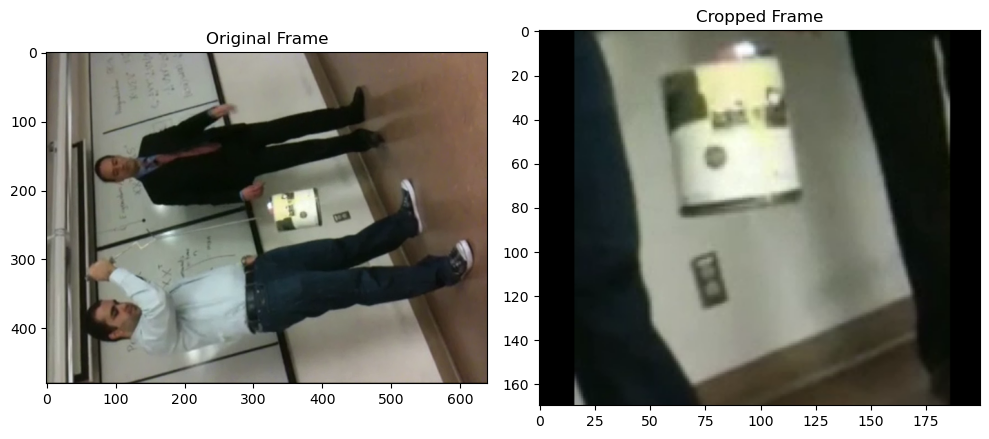

In [191]:
# Extract the 15th frame
first_frame = vid_frames[:, :, :, 50]  
cropped_frame = dataset3[:, :, :, 50]  

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Display the original frame
axes[0].imshow(first_frame)
axes[0].set_title("Original Frame")
axes[0].axis("on")

# Display the cropped frame
axes[1].imshow(cropped_frame)
axes[1].set_title("Cropped Frame")
axes[1].axis("on")

# Show the plots
plt.tight_layout()
plt.show()


In [198]:
create_video_from_dataset(dataset1, "videos/cam1.mp4", fps=30)
create_video_from_dataset(dataset2, "videos/cam2.mp4", fps=30)
create_video_from_dataset(dataset3, "videos/cam3.mp4", fps=30)

Video saved: videos/cam1.mp4
Video saved: videos/cam2.mp4
Video saved: videos/cam3.mp4


In [202]:
#compress datasets and save them so that all steps dont need to be repeated when reopening the file
save_dataset(dataset1, "camera1_cropped.npz")
save_dataset(dataset2, "camera2_cropped.npz")
save_dataset(dataset3, "camera3_cropped.npz")

Dataset saved successfully to 'camera1_cropped.npz'.
Dataset saved successfully to 'camera2_cropped.npz'.
Dataset saved successfully to 'camera3_cropped.npz'.


In [204]:
def track_object_in_video(dataset_path, template_coords, template_frame_index=0, match_threshold=0.65, max_move_distance=20, output_video='tracked_video.mp4', sample_index=100):
    """
    Tracks an object in a video dataset using template matching.
    
    Parameters:
    - dataset_path: str - Path to the .npz dataset containing video frames.
    - template_coords: tuple - (x, y, width, height) defining the template region.
    - match_threshold: float - Minimum acceptable match score.
    - max_move_distance: int - Maximum allowed movement (in pixels) between consecutive frames.
    - output_video: str - Filename for saving the output tracked video.
    - sample_index: int - Index of a frame to visualize results.
    
    Returns:
    - tracked_positions: np.ndarray - Array of tracked positions (x, y) per frame.
    """
    # Load dataset
    data = np.load(dataset_path)
    video_frames = data["data"]  # Expected shape: (H, W, 3, F)
    num_frames = video_frames.shape[3]
    print("Number of frames:", num_frames)

    # Extract template coordinates
    template_x, template_y, template_w, template_h = template_coords
    
    # Get the template from the first frame
    first_frame = video_frames[:, :, :, template_frame_index]
    gray_first = cv2.cvtColor(first_frame, cv2.COLOR_RGB2GRAY)
    equalized_first = cv2.equalizeHist(gray_first)
    blurred_first = cv2.GaussianBlur(equalized_first, (5,5), 0)
    template = blurred_first[template_y:template_y+template_h, template_x:template_x+template_w]
    
    # Display the full frame with axes labeled
    plt.figure(figsize=(8,8))
    plt.imshow(gray_first, cmap="gray")
    plt.title("Full Frame with Axes for Template Selection")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    plt.grid(True)
    plt.show()
    
    # Display the template region
    plt.figure(figsize=(4,4))
    plt.imshow(template, cmap="gray")
    plt.title("Selected Template Region")
    plt.axis("off")
    plt.show()
    
    # Initialize tracking storage
    tracked_positions = np.zeros((num_frames, 2))  # (x, y) coordinates
    overlay_frames = np.copy(video_frames).astype(np.uint8)
    
    for i in range(num_frames):
        frame = video_frames[:, :, :, i]
        
        # Process the frame: grayscale, equalize, and blur
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        equalized = cv2.equalizeHist(gray)
        blurred = cv2.GaussianBlur(equalized, (5,5), 0)
        
        # Apply template matching
        result = cv2.matchTemplate(blurred, template, cv2.TM_CCOEFF_NORMED)
        
        if i == 0:
            _, max_val, _, max_loc = cv2.minMaxLoc(result)
            top_left = max_loc
            center = (top_left[0] + template_w // 2, top_left[1] + template_h // 2)
        else:
            sorted_indices = np.argsort(-result.ravel())
            best_candidate_found = False
            prev_center = tracked_positions[i-1]
            
            for idx in sorted_indices:
                r, c = np.unravel_index(idx, result.shape)
                candidate_score = result[r, c]
                if candidate_score < match_threshold:
                    break
                candidate_center = (c + template_w // 2, r + template_h // 2)
                distance = np.linalg.norm(np.array(candidate_center) - np.array(prev_center))
                if distance <= max_move_distance:
                    best_candidate_found = True
                    top_left = (c, r)
                    center = candidate_center
                    break
            
            if not best_candidate_found:
                center = (int(prev_center[0]), int(prev_center[1]))
                top_left = (center[0] - template_w // 2, center[1] - template_h // 2)
        
        tracked_positions[i] = center
        
        # Draw tracking results
        frame_to_draw = overlay_frames[:, :, :, i].copy()
        bottom_right = (top_left[0] + template_w, top_left[1] + template_h)
        cv2.rectangle(frame_to_draw, top_left, bottom_right, (255, 0, 0), 2)  # Blue rectangle
        cv2.circle(frame_to_draw, center, 3, (0, 255, 0), -1)               # Green dot
        overlay_frames[:, :, :, i] = frame_to_draw
    
    # Display a sample tracked frame
    tracked_sample = overlay_frames[:, :, :, sample_index]
    plt.figure(figsize=(6,6))
    plt.imshow(tracked_sample)
    plt.title("Tracked Sample Frame (Template Matching)")
    plt.axis("off")
    plt.show()
    
    # Save results
    #np.savez_compressed("camera1_tracked.npz", overlayed_frames=overlay_frames, positions=tracked_positions)
    #print("Tracking complete. Overlayed frames and tracked positions saved to 'camera1_tracked.npz'.")
    
    # Create video
    create_video_from_dataset(overlay_frames, output_video)
    print(f"Overlayed video saved as '{output_video}'.")
    
    return tracked_positions

# Example usage:
# track_object_in_video("camera1_cropped.npz", (47, 43, 65, 100), match_threshold=0.65, max_move_distance=20)

Number of frames: 392


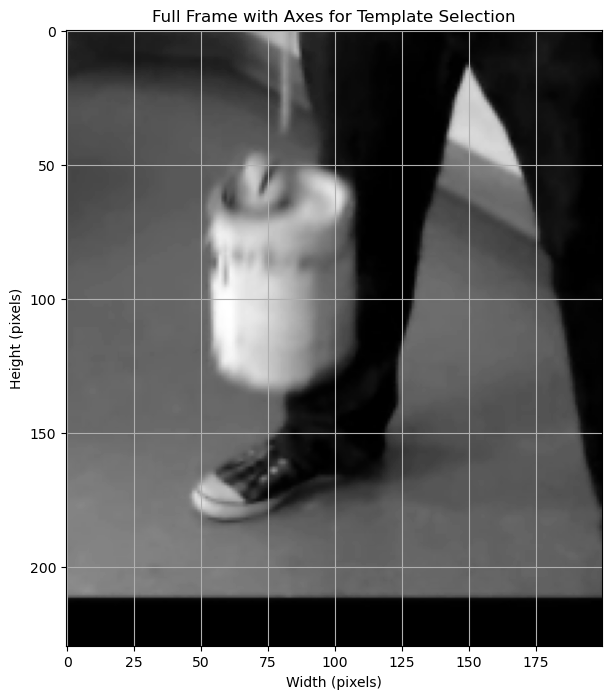

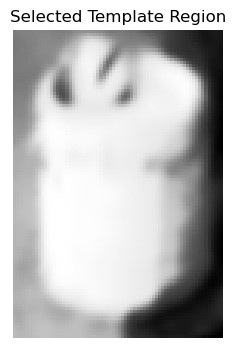

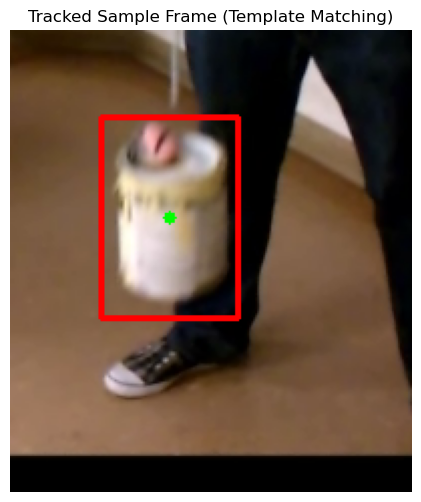

Tracking complete. Overlayed frames and tracked positions saved to 'camera1_tracked.npz'.
Video saved: videos/camera_1_tracked_final.mp4
Overlayed video saved as 'videos/camera_1_tracked_final.mp4'.


In [203]:
#Video 1 - DO NOT TOUCH
cam1_positions = track_object_in_video("camera1_cropped.npz", (45, 43, 68, 100), template_frame_index=100, match_threshold=0.65, max_move_distance=20, output_video='videos/camera_1_tracked_final.mp4', sample_index=100)

In [199]:
#video 2
#Attempts
#1cam2_positions = track_object_in_video("camera2_cropped.npz", (67, 184, 84, 108), template_frame_index=40, match_threshold=0.65, max_move_distance=20, output_video='tracked_video_2.mp4', sample_index=100)

#2cam2_positions = track_object_in_video("camera2_cropped.npz", (67, 180, 96, 110), template_frame_index=80, match_threshold=0.50, max_move_distance=60, output_video='tracked_video_2.mp4', sample_index=100)

#cam2_positions = track_object_in_video("camera2_cropped.npz", (67, 180, 96, 110), template_frame_index=80, match_threshold=0.45, max_move_distance=40, output_video='tracked_video_2.mp4', sample_index=100)
#best so far:
cam2_positions = track_object_in_video("camera2_cropped.npz", (67, 180, 96, 110), template_frame_index=80, match_threshold=0.40, max_move_distance=40, output_video='camera_2_tracked_final.mp4', sample_index=100)

#cam2_positions = track_object_in_video("camera2_cropped.npz", (67, 180, 96, 110), template_frame_index=80, match_threshold=0.38, max_move_distance=40, output_video='tracked_video_2.mp4', sample_index=100)


FileNotFoundError: [Errno 2] No such file or directory: 'camera2_tracked.npz'

Number of frames: 394


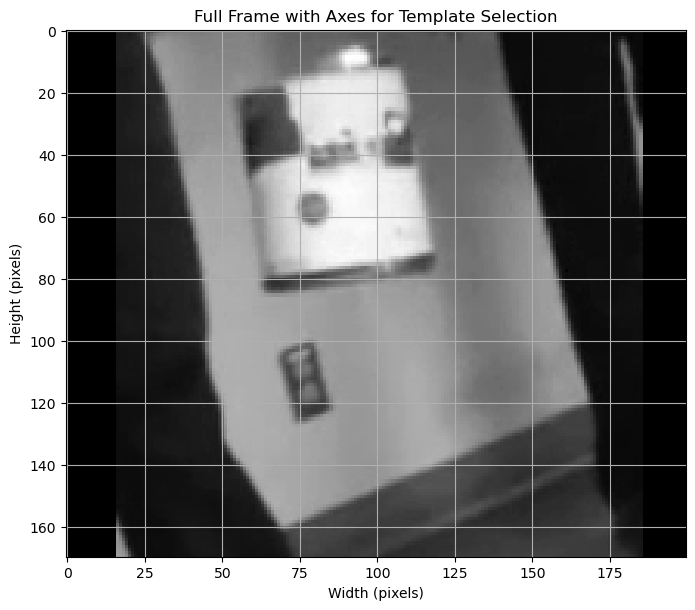

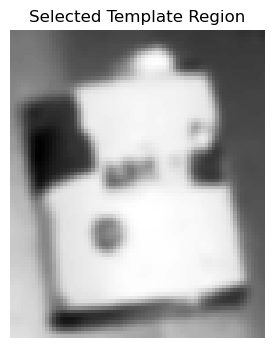

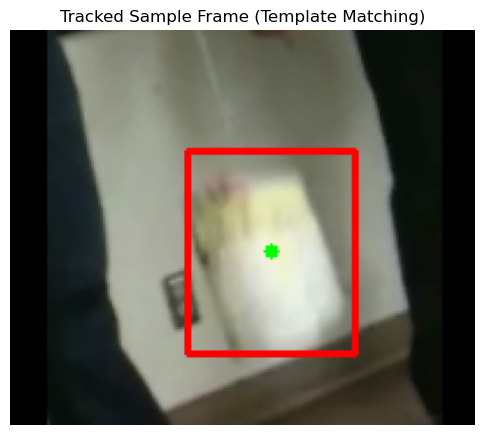

Tracking complete. Overlayed frames and tracked positions saved to 'camera1_tracked.npz'.
Video saved: tracked_video_3.mp4
Overlayed video saved as 'tracked_video_3.mp4'.


In [194]:
#cam 3 attempts
#cam3_positions = track_object_in_video("camera3_cropped.npz", (85, 40, 90, 90), template_frame_index=80, match_threshold=0.50, max_move_distance=30, output_video='tracked_video_3.mp4', sample_index=100)
#cam3_positions = track_object_in_video("camera3_cropped.npz", (85, 40, 90, 90), template_frame_index=80, match_threshold=0.38, max_move_distance=10, output_video='tracked_video_3.mp4', sample_index=100)

#cam3_positions = track_object_in_video("camera3_cropped.npz", (60, 45, 80, 90), template_frame_index=100, match_threshold=0.50, max_move_distance=60, output_video='tracked_video_3.mp4', sample_index=200)
#cam3_positions = track_object_in_video("camera3_cropped.npz", (60, 47, 80, 94), template_frame_index=40, match_threshold=0.40, max_move_distance=40, output_video='tracked_video_3.mp4', sample_index=200)

#cam3_positions = track_object_in_video("camera3_cropped.npz", (60, 47, 80, 94), template_frame_index=40, match_threshold=0.40, max_move_distance=20, output_video='tracked_video_3.mp4', sample_index=200)

#cam3_positions = track_object_in_video("camera3_cropped.npz", (100, 70, 80, 90), template_frame_index=70, match_threshold=0.45, max_move_distance=20, output_video='tracked_video_3.mp4', sample_index=200)

#cam3_positions = track_object_in_video("camera3_cropped.npz", (85, 80, 68, 80), template_frame_index=30, match_threshold=0.40, max_move_distance=80, output_video='tracked_video_3.mp4', sample_index=200)

cam3_positions = track_object_in_video("camera3_tracked.npz", (52, 0, 72, 87), template_frame_index=50, match_threshold=0.39, max_move_distance=15, output_video='tracked_video_3.mp4', sample_index=200)

#resized frame to 300, 510, 130, 300

#cam3_positions = track_object_in_video("camera3_cropped.npz", (59, 0, 70, 87), template_frame_index=50, match_threshold=0.35, max_move_distance=50, output_video='tracked_video_3.mp4', sample_index=200)


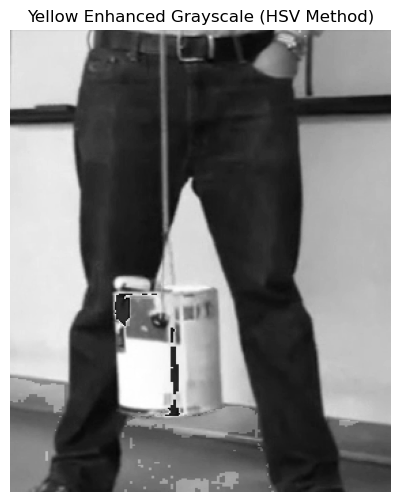

In [23]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the dataset
data = np.load("camera2_cropped.npz")  
video_frames = data["data"]  

# Select a frame to visualize
frame_index = 80  
frame = video_frames[:, :, :, frame_index]  

def enhance_yellow_hsv(frame, increase_brightness=True):
    """
    Enhance yellow in grayscale using HSV masking.
    
    Parameters:
    - frame: np.ndarray - Input RGB frame.
    - increase_brightness: bool - If True, brightens yellow; If False, darkens yellow.
    
    Returns:
    - gray: np.ndarray - Grayscale image with enhanced yellow.
    """
    hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)  # Convert to HSV
    
    # Define yellow color range
    lower_yellow = np.array([25, 50, 50], dtype=np.uint8)  
    upper_yellow = np.array([35, 255, 255], dtype=np.uint8)
    
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)  # Mask yellow areas

    # Modify brightness of only yellow areas
    if increase_brightness:
        hsv[:, :, 2] = np.where(yellow_mask > 0, hsv[:, :, 2] + 50, hsv[:, :, 2])
    else:
        hsv[:, :, 2] = np.where(yellow_mask > 0, hsv[:, :, 2] - 50, hsv[:, :, 2])

    modified_frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)  # Convert back to RGB
    gray = cv2.cvtColor(modified_frame, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    return gray

# Choose whether to brighten or darken yellow
increase_brightness = True  # Change to False to darken yellow

# Process frame
gray = enhance_yellow_hsv(frame, increase_brightness)

# Show result
plt.figure(figsize=(6,6))
plt.imshow(gray, cmap='gray')
plt.title("Yellow Enhanced Grayscale (HSV Method)")
plt.axis("off")
plt.show()


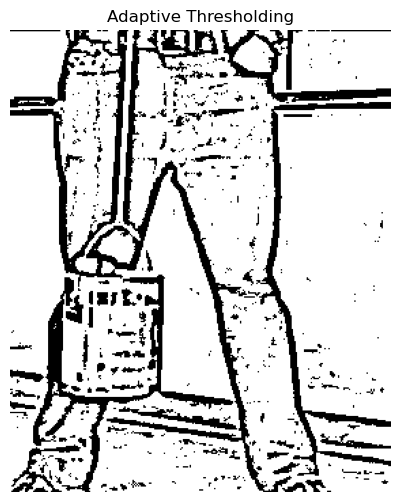

In [27]:
frame_index = 120  
frame = video_frames[:, :, :, frame_index]

gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Convert to grayscale

# Adaptive thresholding
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                               cv2.THRESH_BINARY, 11, 2)

# Show result
plt.figure(figsize=(6,6))
plt.imshow(thresh, cmap='gray')
plt.title("Adaptive Thresholding")
plt.axis("off")
plt.show()

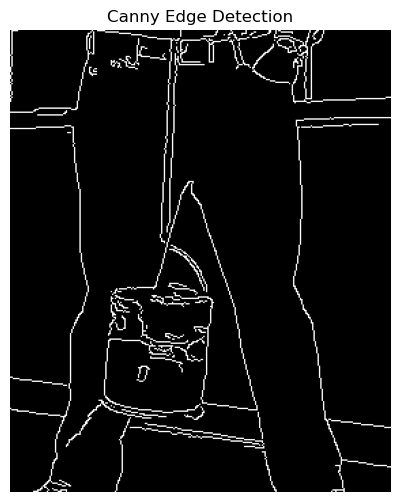

In [30]:
frame_index = 40  
frame = video_frames[:, :, :, frame_index]

gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Convert to grayscale

# Apply Canny Edge Detection
edges = cv2.Canny(gray, 50, 150)

# Show result
plt.figure(figsize=(6,6))
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis("off")
plt.show()

Number of frames: 405


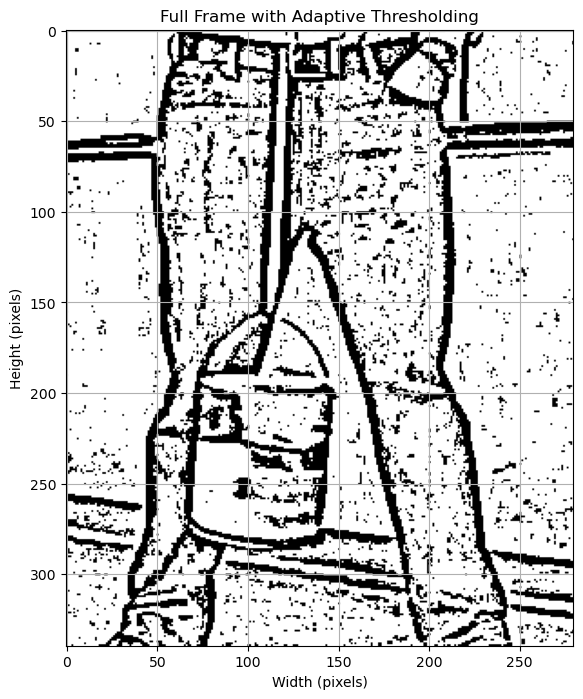

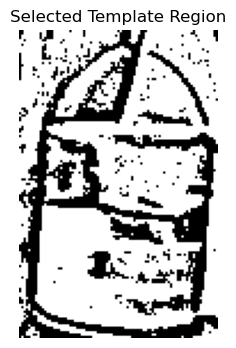

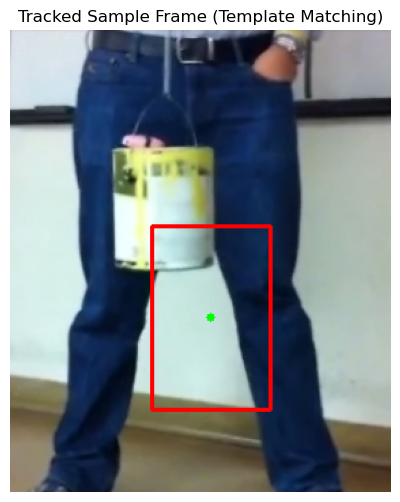

Tracking complete. Overlayed frames and tracked positions saved to 'camera1_tracked.npz'.


In [35]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def track_object_in_video_adaptive(dataset_path, template_coords, template_frame_index=0, match_threshold=0.65, 
                          max_move_distance=20, output_video='tracked_video.mp4', sample_index=100):
    """
    Tracks an object in a video dataset using template matching with adaptive thresholding.
    
    Parameters:
    - dataset_path: str - Path to the .npz dataset containing video frames.
    - template_coords: tuple - (x, y, width, height) defining the template region.
    - match_threshold: float - Minimum acceptable match score.
    - max_move_distance: int - Maximum allowed movement (in pixels) between consecutive frames.
    - output_video: str - Filename for saving the output tracked video.
    - sample_index: int - Index of a frame to visualize results.
    
    Returns:
    - tracked_positions: np.ndarray - Array of tracked positions (x, y) per frame.
    """
    # Load dataset
    data = np.load(dataset_path)
    video_frames = data["data"]  # Expected shape: (H, W, 3, F)
    num_frames = video_frames.shape[3]
    print("Number of frames:", num_frames)

    # Extract template coordinates
    template_x, template_y, template_w, template_h = template_coords
    
    # Get the template from the first frame
    first_frame = video_frames[:, :, :, template_frame_index]
    
    # Convert to grayscale using adaptive thresholding
    gray_first = cv2.cvtColor(first_frame, cv2.COLOR_RGB2GRAY)
    thresh_first = cv2.adaptiveThreshold(gray_first, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                         cv2.THRESH_BINARY, 11, 2)
    
    template = thresh_first[template_y:template_y+template_h, template_x:template_x+template_w]
    
    # Display the full frame with axes labeled
    plt.figure(figsize=(8,8))
    plt.imshow(thresh_first, cmap="gray")
    plt.title("Full Frame with Adaptive Thresholding")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    plt.grid(True)
    plt.show()
    
    # Display the template region
    plt.figure(figsize=(4,4))
    plt.imshow(template, cmap="gray")
    plt.title("Selected Template Region")
    plt.axis("off")
    plt.show()
    
    # Initialize tracking storage
    tracked_positions = np.zeros((num_frames, 2))  # (x, y) coordinates
    overlay_frames = np.copy(video_frames).astype(np.uint8)
    
    for i in range(num_frames):
        frame = video_frames[:, :, :, i]
        
        # Convert to grayscale and apply adaptive thresholding
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                       cv2.THRESH_BINARY, 11, 2)
        
        # Apply template matching
        result = cv2.matchTemplate(thresh, template, cv2.TM_CCOEFF_NORMED)
        
        if i == 0:
            _, max_val, _, max_loc = cv2.minMaxLoc(result)
            top_left = max_loc
            center = (top_left[0] + template_w // 2, top_left[1] + template_h // 2)
        else:
            sorted_indices = np.argsort(-result.ravel())
            best_candidate_found = False
            prev_center = tracked_positions[i-1]
            
            for idx in sorted_indices:
                r, c = np.unravel_index(idx, result.shape)
                candidate_score = result[r, c]
                if candidate_score < match_threshold:
                    break
                candidate_center = (c + template_w // 2, r + template_h // 2)
                distance = np.linalg.norm(np.array(candidate_center) - np.array(prev_center))
                if distance <= max_move_distance:
                    best_candidate_found = True
                    top_left = (c, r)
                    center = candidate_center
                    break
            
            if not best_candidate_found:
                center = (int(prev_center[0]), int(prev_center[1]))
                top_left = (center[0] - template_w // 2, center[1] - template_h // 2)
        
        tracked_positions[i] = center
        
        # Draw tracking results
        frame_to_draw = overlay_frames[:, :, :, i].copy()
        bottom_right = (top_left[0] + template_w, top_left[1] + template_h)
        cv2.rectangle(frame_to_draw, top_left, bottom_right, (255, 0, 0), 2)  # Blue rectangle
        cv2.circle(frame_to_draw, center, 3, (0, 255, 0), -1)               # Green dot
        overlay_frames[:, :, :, i] = frame_to_draw
    
    # Display a sample tracked frame
    tracked_sample = overlay_frames[:, :, :, sample_index]
    plt.figure(figsize=(6,6))
    plt.imshow(tracked_sample)
    plt.title("Tracked Sample Frame (Template Matching)")
    plt.axis("off")
    plt.show()
    
    # Save results
    np.savez_compressed("camera1_tracked.npz", overlayed_frames=overlay_frames, positions=tracked_positions)
    print("Tracking complete. Overlayed frames and tracked positions saved to 'camera1_tracked.npz'.")
    
    return tracked_positions

# Example usage:
# track_object_in_video("camera1_cropped.npz", (47, 43, 65, 100), match_threshold=0.65, max_move_distance=20)

Number of frames: 405


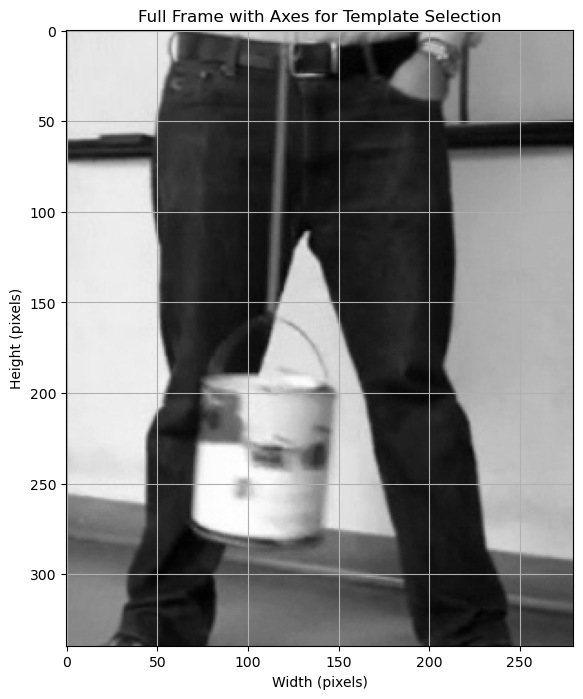

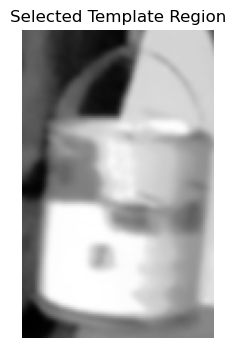

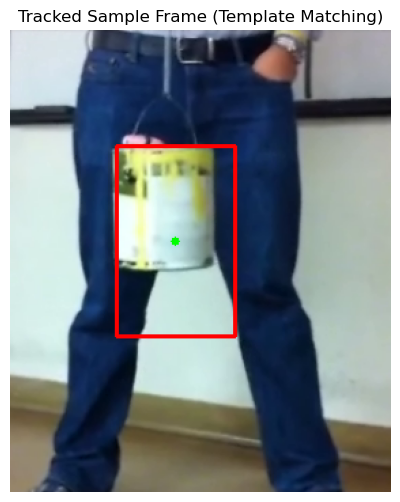

Tracking complete. Overlayed frames and tracked positions saved to 'camera1_tracked.npz'.
Video saved: tracked_video_2.mp4
Overlayed video saved as 'tracked_video_2.mp4'.


In [196]:
#camera 2

#cam2_positions = track_object_in_video("camera2_cropped.npz", (62, 150, 87, 140), template_frame_index=40, match_threshold=0.60, max_move_distance=20, output_video='tracked_video_2.mp4', sample_index=100)

cam2_positions = track_object_in_video("camera2_cropped.npz", (62, 150, 87, 140), template_frame_index=40, match_threshold=0.60, max_move_distance=20, output_video='tracked_video_2.mp4', sample_index=100)

In [56]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def track_object_with_edges(dataset_path, template_coords, template_frame_index=0, match_threshold=0.65, 
                            max_move_distance=20, output_video='tracked_video.mp4', sample_index=100):
    """
    Tracks an object in a video dataset using template matching with Canny Edge Detection.
    
    Parameters:
    - dataset_path: str - Path to the .npz dataset containing video frames.
    - template_coords: tuple - (x, y, width, height) defining the template region.
    - match_threshold: float - Minimum acceptable match score.
    - max_move_distance: int - Maximum allowed movement (in pixels) between consecutive frames.
    - output_video: str - Filename for saving the output tracked video.
    - sample_index: int - Index of a frame to visualize results.
    
    Returns:
    - tracked_positions: np.ndarray - Array of tracked positions (x, y) per frame.
    """
    # Load dataset
    data = np.load(dataset_path)
    video_frames = data["data"]  # Expected shape: (H, W, 3, F)
    num_frames = video_frames.shape[3]
    print("Number of frames:", num_frames)

    # Extract template coordinates
    template_x, template_y, template_w, template_h = template_coords
    
    # Get the template from the first frame
    first_frame = video_frames[:, :, :, template_frame_index]
    
    # Convert to grayscale and apply Canny Edge Detection
    gray_first = cv2.cvtColor(first_frame, cv2.COLOR_RGB2GRAY)
    edges_first = cv2.Canny(gray_first, 50, 150)  # Canny edge detection
    
    template = edges_first[template_y:template_y+template_h, template_x:template_x+template_w]
    
    # Display the full frame with detected edges
    plt.figure(figsize=(8,8))
    plt.imshow(edges_first, cmap="gray")
    plt.title("Full Frame with Canny Edge Detection")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    plt.grid(True)
    plt.show()
    
    # Display the template region
    plt.figure(figsize=(4,4))
    plt.imshow(template, cmap="gray")
    plt.title("Selected Template Region")
    plt.axis("off")
    plt.show()
    
    # Initialize tracking storage
    tracked_positions = np.zeros((num_frames, 2))  # (x, y) coordinates
    overlay_frames = np.copy(video_frames).astype(np.uint8)
    
    for i in range(num_frames):
        frame = video_frames[:, :, :, i]
        
        # Convert to grayscale and apply Canny Edge Detection
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, 50, 150)  # Edge detection
        
        # Apply template matching
        result = cv2.matchTemplate(edges, template, cv2.TM_CCOEFF_NORMED)
        
        if i == 0:
            _, max_val, _, max_loc = cv2.minMaxLoc(result)
            top_left = max_loc
            center = (top_left[0] + template_w // 2, top_left[1] + template_h // 2)
        else:
            sorted_indices = np.argsort(-result.ravel())
            best_candidate_found = False
            prev_center = tracked_positions[i-1]
            
            for idx in sorted_indices:
                r, c = np.unravel_index(idx, result.shape)
                candidate_score = result[r, c]
                if candidate_score < match_threshold:
                    break
                candidate_center = (c + template_w // 2, r + template_h // 2)
                distance = np.linalg.norm(np.array(candidate_center) - np.array(prev_center))
                if distance <= max_move_distance:
                    best_candidate_found = True
                    top_left = (c, r)
                    center = candidate_center
                    break
            
            if not best_candidate_found:
                center = (int(prev_center[0]), int(prev_center[1]))
                top_left = (center[0] - template_w // 2, center[1] - template_h // 2)
        
        tracked_positions[i] = center
        
        # Draw tracking results
        frame_to_draw = overlay_frames[:, :, :, i].copy()
        bottom_right = (top_left[0] + template_w, top_left[1] + template_h)
        cv2.rectangle(frame_to_draw, top_left, bottom_right, (255, 0, 0), 2)  # Blue rectangle
        cv2.circle(frame_to_draw, center, 3, (0, 255, 0), -1)               # Green dot
        overlay_frames[:, :, :, i] = frame_to_draw
    
    # Display a sample tracked frame
    tracked_sample = overlay_frames[:, :, :, sample_index]
    plt.figure(figsize=(6,6))
    plt.imshow(tracked_sample)
    plt.title("Tracked Sample Frame (Template Matching with Edges)")
    plt.axis("off")
    plt.show()
    
    # Save results
    np.savez_compressed("camera1_tracked.npz", overlayed_frames=overlay_frames, positions=tracked_positions)
    print("Tracking complete. Overlayed frames and tracked positions saved to 'camera1_tracked.npz'.")
    
    return tracked_positions

# Example usage:
# track_object_with_edges("camera1_cropped.npz", (47, 43, 65, 100), match_threshold=0.65, max_move_distance=20)


Number of frames: 405


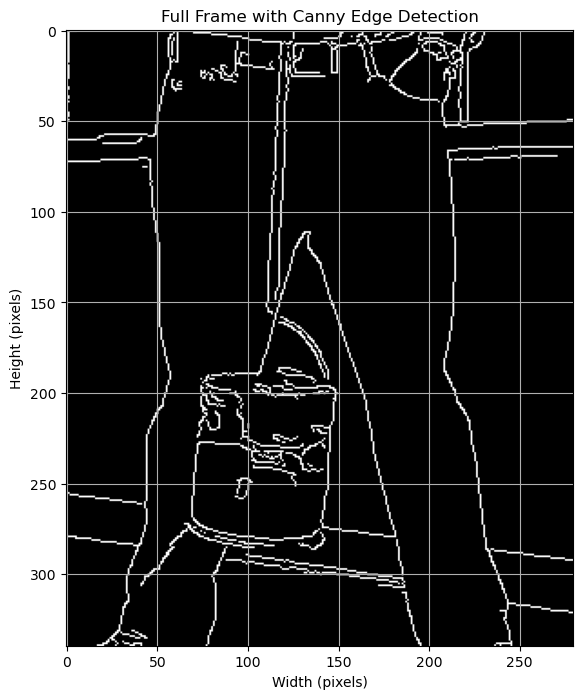

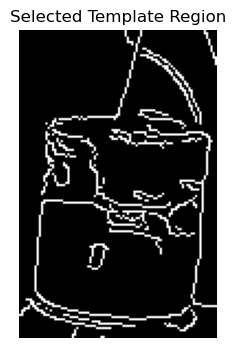

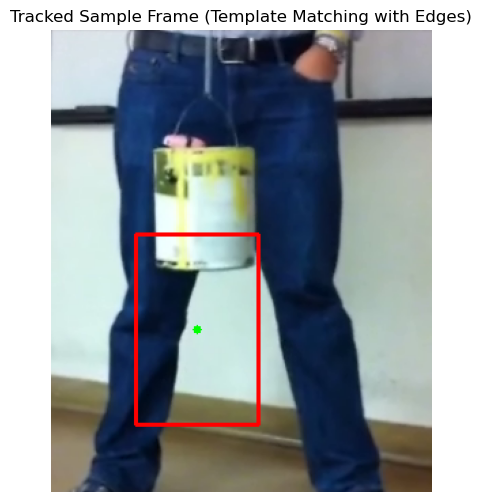

Tracking complete. Overlayed frames and tracked positions saved to 'camera1_tracked.npz'.


In [57]:
cam2_positions = track_object_with_edges("camera2_cropped.npz", (62, 150, 90, 140), template_frame_index=40, match_threshold=0.30, max_move_distance=100, output_video='tracked_video_2.mp4', sample_index=100)